In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    if target_type in (np.int64, np.int32):
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

    

In [2]:
import tensorflow as tf
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

df

x,y = to_xy(df,['mpg'])

model_dir = 'tmp/mpg1' 

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = skflow.DNNRegressor(
    model_dir= model_dir,
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])

regressor.fit(x, y,steps=1000)

pred = list(regressor.predict(x, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

pred = list(regressor.predict(x, as_iterable=True))
predDF = pd.DataFrame(pred)
df2 = pd.concat([df,predDF,pd.DataFrame(y)],axis=1)

df2.columns = list(df.columns)+['pred','ideal']
df2



Final score (RMSE): 0.18995149433612823


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3,pred,ideal
0,18.0,1.496308,1.089233,0.672271,0.630077,-1.293870,70,1,0,0,17.913458,18.0
1,15.0,1.496308,1.501624,1.587959,0.853259,-1.475181,70,1,0,0,14.878858,15.0
2,18.0,1.496308,1.194728,1.195522,0.549778,-1.656492,70,1,0,0,17.878546,18.0
3,16.0,1.496308,1.060461,1.195522,0.546236,-1.293870,70,1,0,0,15.882986,16.0
4,17.0,1.496308,1.041280,0.933897,0.565130,-1.837804,70,1,0,0,16.907516,17.0
5,15.0,1.496308,2.259274,2.451322,1.618455,-2.019115,70,1,0,0,14.791887,15.0
6,14.0,1.496308,2.499036,3.026898,1.633806,-2.381737,70,1,0,0,13.774524,14.0
7,14.0,1.496308,2.364769,2.896085,1.584210,-2.563048,70,1,0,0,13.781412,14.0
8,14.0,1.496308,2.508627,3.157710,1.717647,-2.019115,70,1,0,0,13.739818,14.0
9,15.0,1.496308,1.885244,2.242022,1.038654,-2.563048,70,1,0,0,14.849905,15.0


In [3]:
import tensorflow.contrib.learn as learn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

x,y = to_xy(df,'mpg')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model_dir = 'tmp/mpg2' 

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)



DNNRegressor(feature_columns=[_RealValuedColumn(column_name='', dimension=398, default_value=None, dtype=tf.float32, normalizer=None)], optimizer=None, dropout=None, hidden_units=[50, 25, 10])

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)

pred = list(regressor.predict(x_test, as_iterable=True))

score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))



Final score (MSE): 5.466667175292969


In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))



Final score (RMSE): 2.338090419769287


In [6]:
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

x,y = to_xy(df,'mpg')

kf = KFold(5)
    
all_y = []
all_pred = []
fold = 0
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model_dir = 'tmp/mpgKF' + str(fold)

    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
    regressor = learn.DNNRegressor(
        model_dir= model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
        feature_columns=feature_columns,
        hidden_units=[50, 25, 10])

    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        x_test,
        y_test,
        every_n_steps=50,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=50)
    
    regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

    pred = list(regressor.predict(x_test, as_iterable=True))
    
    all_y.append(y_test)
    all_pred.append(pred)        

    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
score = np.sqrt(metrics.mean_squared_error(all_pred,all_y))
print("Final, out of sample score (RMSE): {}".format(score))    
    
all_y = pd.DataFrame(all_y)
all_pred = pd.DataFrame(all_pred)
allDF = pd.concat( [df, all_y, all_pred],axis=1 )
allDF.to_csv(filename_write,index=False)



Fold #1
Fold score (RMSE): 2.7842540740966797
Fold #2
Fold score (RMSE): 3.394286870956421
Fold #3
Fold score (RMSE): 3.275982618331909
Fold #4
Fold score (RMSE): 3.941182851791382
Fold #5
Fold score (RMSE): 3.4482271671295166
Final, out of sample score (RMSE): 3.3874053955078125


In [7]:
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-holdout.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

x,y = to_xy(df,'mpg')

x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 

kf = KFold(5)
    
all_y = []
all_pred = []
fold = 0
for train, test in kf.split(x_main):        
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model_dir = 'tmp/mpgKFHS' + str(fold)

    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
    regressor = learn.DNNRegressor(
        model_dir= model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
        feature_columns=feature_columns,
        hidden_units=[50, 25, 10])

    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        x_test,
        y_test,
        every_n_steps=50,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=50)
    
    regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

    pred = list(regressor.predict(x_test, as_iterable=True))
    
    all_y.append(y_test)
    all_pred.append(pred)        

    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))

all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
score = np.sqrt(metrics.mean_squared_error(all_pred,all_y))
print()
print("Cross-validated score (RMSE): {}".format(score))    
    
holdout_pred = list(regressor.predict(x_holdout, as_iterable=True))

score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print("Holdout score (RMSE): {}".format(score))    



Fold #1
Fold score (RMSE): 3.7783710956573486
Fold #2
Fold score (RMSE): 3.3557262420654297
Fold #3
Fold score (RMSE): 3.524622678756714
Fold #4
Fold score (RMSE): 3.0937066078186035
Fold #5
Fold score (RMSE): 3.7664620876312256

Cross-validated score (RMSE): 3.51369309425354
Holdout score (RMSE): 2.8932342529296875


In [8]:
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
    

Score (RMSE): 2.9808456897735596


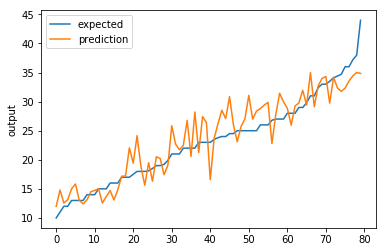

In [9]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow.contrib.learn as learn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

x,y = to_xy(df,'mpg')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model_dir = 'tmp/mpg3' 

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50,25,10])

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
regressor.fit(x_train, y_train,monitors=[validation_monitor],batch_size=32,steps=10000)

pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

chart_regression(pred,y_test)

